# 5. Übungsblatt: Trainieren eines Klassifizierers auf dem STL-10 Datensatz
In diesem Notebook werden wir wieder einen Klassifizierer in Pytorch implementieren, mit dem Unterschied, dass wir dieses Mal ein CNN statt einem MLP für die Klassifizierung verwenden werden. Als Datensatz verwenden wir den STL-10 Datensatz. Der STL-10 Datensatz enthält Bilder von Flugzeugen, Vögeln, Katzen und vielem mehr, jeweils mit einer Auflösung von $96 \times 96$ Pixeln. Wir haben uns für diesen Datensatz entschieden, damit das Training auch auf Leistungsschwächeren Computern läuft, z.B. welche ohne Grafikkarte.

Klassifizierer arbeiten jedoch nicht mit der textuellen Beschreibung von Objekten wie z.B. "Airplane", "Bird", "Car" usw. stattdessen wird jede Klasse mit einer Zahl repräsentiert. Diese Repräsentierung legen wir als erstes fest, da uns dies später einiges erleichtern wird. Hierfür wählen wir die lexikographische Sortierung der Klassennamen und indizieren gemäß dieser Reihenfolge. Das Ergebnis speichern wir in einem Dictionary (eine Liste wäre allerdings auch ausreichend).

## 1. Daten einlesen (ToDo)
Als nächstes definieren wir den Pfad zu den Bildern *root_dir* und den Pfad, an dem wir später unsere trainierten Gewichte inkl. Optimiererdaten und Trainingsergebnisse speichern werden *checkpoint_dir*. In dem Verzeichnis, in dem Sie dieses Notebook speichern, wird ein Ordner angelegt mit dem Namen *Checkpoints*. Anschließend definieren wir zwei Pfade inkl. Dateinamen für diese Checkpoints. Ein Checkpoint enthält einen Zeitstempel im Dateinamen, der andere nicht. Wenn Sie später ihr Modell testen oder nochmal trainieren möchten, wird immer der Checkpoint ohne Zeitstempel zum Laden verwendet.

In [59]:
import os
import numpy as np
import random
import glob

import torch
import torchvision
from torch.utils.data import Dataset

# from PIL import Image
import cv2

from tqdm import tqdm   # Progress-Bar

# Setze einen Seed für die Reproduzierbarkeit.
torch.manual_seed(1)

class_map_idx_to_str = {0: 'airplane',
                        1: 'bird', 
                        2: 'car', 
                        3: 'cat', 
                        4: 'deer', 
                        5: 'dog', 
                        6: 'horse', 
                        7: 'monkey', 
                        8: 'ship', 
                        9: 'truck'}

def get_labels():
    return [class_map_idx_to_str[key] for key in class_map_idx_to_str.keys()]


def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed_everything(1)

# Definiere den Pfad zu den Ordnern train, val und test.
root_dir = os.getcwd() + os.sep + "STL-10_Dataset\\"

# Definiere den Pfad zu den trainierten Gewichten.
checkpoint_dir = os.getcwd() + os.sep + "Checkpoints" + os.sep

checkpoint_path = os.getcwd() + "/Checkpoints/checkpoint.pth.tar"

# Erstelle einen neuen Ordner Checkpoints im aktuellen Verzeichnis.
if not os.path.isdir(os.getcwd() + "/Checkpoints/"):
    os.makedirs(os.getcwd() + "/Checkpoints/")

# Lade den aktuellen Checkpoint (falls vorhanden), ansonsten erstelle einen neuen.
def create_or_load_checkpoint(model, epoch=-1, optimizer=None, last_loss=10**20):
    if os.path.isfile(checkpoint_path):
        print("=> Looking for checkpoint")
        try:
            checkpoint = torch.load(checkpoint_path)
            epoch = checkpoint['epoch']
            print("Loaded epoch number is", epoch)            
            last_loss = checkpoint['best_loss']
            print("Loaded best loss is", last_loss)
            model.load_state_dict(checkpoint['state_dict'], strict=False)
            if not optimizer is None:
                optimizer.load_state_dict(checkpoint['optimizer'])
            print("=> Found and loaded checkpoint")
        except:
            print("Your checkpoint does not contain trained weights. Your old weights will be overwritten.")
            torch.save({'epoch': epoch, 'state_dict': model.state_dict(), 'best_loss': last_loss, 'optimizer': optimizer.state_dict()}, checkpoint_path)
    else:
        torch.save({'epoch': epoch, 'state_dict': model.state_dict(), 'best_loss': last_loss, 'optimizer': optimizer.state_dict()}, checkpoint_path)
        print("=> No checkpoint found. You have to train first.")
    return epoch, last_loss

## 2. Bilder laden und Exkurs zu Augmentierungen (ToDo + Bonusaufgabe)
Im folgenden Abschnitt laden wir die Bilder. Wenn Sie die Bonusaufgabe machen möchten, sollen die Bilder nicht mehr nur im originalen Zustand dem Training übergeben werden, sondern die Bilder sollen zovor augmentiert werden. Das heißt, die Bilder sollen mit einer Wahrscheinlichkeit von:
 * 75% rotiert werden. Die Rotation soll im Bereich -15 bis +15 Grad liegen. (2 Punkte)
 * 50% an der vertikalen Achse gespiegelt werden. (1 Punkt)

Weitere gängige Augmentierungsmethoden, die Sie freiwillig implementieren können, sind z.B.
1. Änderung in Helligkeit, Sättigung und Farbwert: verwende HSV statt RGB und ändere H (Hue), S (Saturation) und V (Value)
2. Verschiebung: Bild wird etwas nach oben, unten, links oder rechts verschoben.
3. Skalierung: Bild wird vergrößert oder verkleinert
4. Scherung: Bild wird geschert: Eine Seite bleibt fest, die gegenüberliegende Seite wird verschoben
5. Crops: Statt dem gesamten Bild werden dem Modell nur Teile des Bildes gezeigt (meist zufällige Bildausschnitte und mehrere)
6. Rauschen: Auf das Bild wird ein verrauschtes Array addiert

Die Idee der Augmentierung ist, dass man künstlich die Anzahl der Eingabebilder vergrößert. Mittlerweile ist man so weit, dass man neuronale Netze verwendet, sogenannte GANs (Generative Adversarial Network), die für einen gegebenen Datensatz, die Verteilung dieses Datensatzes lernen. Dadurch lassen sich ähnliche, täuschend echte Bilder erzeugen, die wiederum für ein anderes Netz verwendet werden können. Diese Technik verwendet man häufig bei Daten für die es sehr schwer ist gelabelte Daten zu bekommen, z.B. Sensordaten für Aktivitätserkennung.

In [60]:
def list_subdirs(path):
    ps = []
    for file in os.listdir(path):
        if os.path.isdir(os.path.join(path, file)):
            ps += [file]
    return ps

def list_files(path):
    ps = []
    for file in os.listdir(path):
        if not os.path.isdir(os.path.join(path, file)):
            ps += [file]
    return ps

def get_index(val):
    for k in class_map_idx_to_str.keys():
        if class_map_idx_to_str[k] == val:
            return k

def rotate_image(image, angle):
    image_center = tuple(np.array(image.shape[1::-1]) / 2)
    rot_mat = cv2.getRotationMatrix2D(image_center, angle, 1.0)
    result = cv2.warpAffine(image, rot_mat, image.shape[1::-1], flags=cv2.INTER_LINEAR)
    return result


class Simple_Dataloader(Dataset):
    def __init__(self, root_dir, loader_mode):
        print(loader_mode)
        self.root_dir = root_dir
        self.loader_mode = loader_mode

        if not loader_mode in ["train", "val", "test"]:
            raise Exception

        self.root_dir += self.loader_mode + os.sep
        print(self.root_dir)

        self.imgs = []
        self.c = []

        for c in list_subdirs(self.root_dir):
            # print(c)
            # self.data[c] = []
            for f in list_files(self.root_dir + c + os.sep):
                self.imgs += [f]
                self.c += [c]

        self.imgs, self.c = zip(*sorted(zip(self.imgs, self.c)))
        # print(self.data)

        self.transform = torchvision.transforms.Compose([
            torchvision.transforms.ToTensor()
        ])

    def __len__(self):
        return len(self.imgs)

    def __getitem__(self, idx):
        flip = bool(random.randint(0,1))
        rotate = bool(random.randint(0,3))
        deg = random.randint(-15,15)

        lbl = self.c[idx]

        lbl_index = get_index(lbl)

        img_path = self.root_dir + lbl + os.sep + self.imgs[idx]

        img = cv2.imread(img_path, cv2.IMREAD_COLOR)
        if flip:
            img = cv2.flip(img, 0)
        if rotate:
            img = rotate_image(img, deg)

        # Transform Numpy Array into Pytorch Tensor
        img_torch = self.transform(img)
        
        # Flatten Tensor
        #img_torch = torch.flatten(img_torch)
        return img_torch, lbl_index

loader = Simple_Dataloader(root_dir, "test")
print(loader[0])

test
c:\Users\TUK\Documents\_Uni\ki\U05\STL-10_Dataset\test\
(tensor([[[0.2392, 0.1373, 0.2275,  ..., 0.0235, 0.0039, 0.0000],
         [0.2431, 0.1529, 0.0706,  ..., 0.0039, 0.0157, 0.0157],
         [0.0980, 0.2784, 0.0549,  ..., 0.0235, 0.0235, 0.0078],
         ...,
         [0.0000, 0.0196, 0.0824,  ..., 0.5882, 0.5882, 0.6039],
         [0.0627, 0.1608, 0.1216,  ..., 0.5216, 0.5608, 0.5804],
         [0.1294, 0.2235, 0.1843,  ..., 0.4039, 0.4510, 0.5176]],

        [[0.4627, 0.3490, 0.4039,  ..., 0.1059, 0.0706, 0.0667],
         [0.3804, 0.2745, 0.1412,  ..., 0.1020, 0.1059, 0.1020],
         [0.1451, 0.4000, 0.1412,  ..., 0.1412, 0.1412, 0.1216],
         ...,
         [0.2549, 0.2549, 0.2941,  ..., 0.7059, 0.6863, 0.6941],
         [0.3294, 0.4392, 0.3490,  ..., 0.6431, 0.6667, 0.6902],
         [0.4039, 0.5176, 0.4275,  ..., 0.5451, 0.5725, 0.6353]],

        [[0.4588, 0.3255, 0.3765,  ..., 0.1098, 0.0784, 0.0745],
         [0.3961, 0.2863, 0.1569,  ..., 0.1020, 0.1059, 0.105

## 2. Dataset zu Dataloader (nothing ToDo)
Wir übergeben das Dataset dem Dataloader.

In [61]:
batch_size_train = 16 # 88
batch_size_val = 1

print("Cache Data:")

train_dataset = Simple_Dataloader(root_dir=root_dir, loader_mode="train")
val_dataset = Simple_Dataloader(root_dir=root_dir, loader_mode="val")
test_dataset = Simple_Dataloader(root_dir=root_dir, loader_mode="test")


train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size_train, pin_memory=True,
                                               shuffle=True, drop_last=False)

val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size_val, pin_memory=True,
                                             shuffle=False, drop_last=True)

test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=1, pin_memory=True,
                                              shuffle=False, drop_last=False)

dataset_sizes = dict()
dataset_sizes["train"] = len(train_dataset)
dataset_sizes["val"] = len(val_dataset)
dataset_sizes["test"] = len(test_dataset)
dataset_sizes

Cache Data:
train
c:\Users\TUK\Documents\_Uni\ki\U05\STL-10_Dataset\train\
val
c:\Users\TUK\Documents\_Uni\ki\U05\STL-10_Dataset\val\
test
c:\Users\TUK\Documents\_Uni\ki\U05\STL-10_Dataset\test\


{'train': 4250, 'val': 250, 'test': 500}

## 3. Plotten von Zwischenergebnissen (nothing ToDo)
Später, während des Trainings und der Validierung, möchten wir gerne einige Zwischenergebnisse sehen. Hierfür verwenden wir die nachfolgende Methode. Dabei wird in Ihrem Verzeichnis ein Ordner mit dem Namen *Some Results [YYYY-MM-DD HH_MM_SS]* (Zeitstempel kommt von oben) angelegt. Darin finden Sie nach ausreichend langem Training, zwei Unterordner *train* und *val*. Beide Unterordner enthalten die Zwischenergebnisse. Die Dateinamen sehen wie folgt aus:
  
<br>
<center>Epoch_e;cls_i.png</center>

und bedeuten, dass das gezeigte Bild in der Epoche e, Iteration i, als Klasse cls klassifiziert wurde.
<br>  
<br>  
<br>  

### 3.1 Pytorch Tensoren und ihre Dimensionsreihenfolge (nothing ToDo)
Ein Pytorch Tensor hat in der Regel folgende shape:

<br>
<center>[batch_size, num_channels, height, width]</center>

Das heißt, um ein RGB Bild zu plotten müssen wir uns erst einmal für einen Batchindex entscheiden. Um unnötigen Ärger mit nichtvorhandenen Indizes zu vermeiden, wählen wir im nächsten Abschnitt *batch_idx = 0*, somit bekommen wir auch keinen Fehler, selbst wenn wir mit einer Minibatch von *batch_size = 1* trainieren. Folglich ist *inp* von der Form:

<br>
<center>[num_channels, height, width]</center>

Ein weiterer Unterschied bezüglich der Dimensionsreihenfolge zwischen der Pytorch Tensoren und numpy Arrays ist, dass bei numpy Arrays die Channels am Ende stehen. Um diese Reihenfolge anzupassen, verwenden wir im folgenden:

<br>
<center>inp.transpose((1, 2, 0))</center>

Das heißt die erste Dimension wird an die nullte Dimension, die zeite Dimension an die erste Dimension und die nullte an die zweite Dimension verschoben. Oft spricht man auch von *channel first* oder *channel last*.

<br>
Da die Pytorch Tensoren Float-Tensoren sind, enthalten die Channels Werte zwischen 0 und 1. Wenn wir aber mit PIL (Pillow) ein Bild speichern möchten, müssen wir den Tensor zu einem uint8 Format casten (Restklassenring Z/256Z) und sicherstellen, dass die Werte zwischen 0 und 255 liegen.

In [62]:
def plot_some_results(inputs, preds, class_map, img_counter, epoch, phase):
    batch_idx = 0
    
    # Den Teil ".cpu().detach()" brauchen wir hier nicht unbedingt, da wir nicht auf einer Grafikkarte arbeiten.
    # Könnte aber für alle interessant sein, die das Zuhause auf ihrem eigenen PC mit GPU Unterstüzung laufen lassen.
    inp = np.array(inputs.cpu().detach().numpy()[batch_idx], dtype=np.float32)
    
    means = [0.485, 0.456, 0.406]
    stds = [0.229, 0.224, 0.225]
    
    # Da die Bilder zuvor normalisiert wurden, müssen wir dies erst rückgängig machen.
    for channel in range(3):
        inp[channel] = inp[channel] * stds[channel] + means[channel]
        inp[channel] = np.minimum(np.maximum(inp[channel], 0), 1)    
    
    inp = np.array(inp.transpose((1, 2, 0)) * 255.0, dtype=np.uint8)
    class_name = class_map[int(preds[batch_idx])]

    save_dir_results = os.getcwd() + os.sep + "Results" + os.sep + phase + os.sep

    if not os.path.isdir(save_dir_results):
        os.makedirs(save_dir_results)
    
    save_path = save_dir_results + "Epoch_" + str(epoch) + ";" + class_name + "_" + str(img_counter) + ".png"
    cv2.imwrite(save_path, inp)
    img_counter += 1

## 4. Convolutional Neural Network definieren (ToDo)
Im folgenden betrachten wir drei Modelle

0. Small_Model
1. Our_First_CNN
2. ResNet34

Das *Small_Model* soll Ihnen Hilfestellung geben, wie ein CNN implementiert werden kann. Dabei wurden einige aus der Vorlesung bekannte Konzepte wie z.B. die Convolution Operation (```nn.Conv2d```), Dropout (```nn.Dropout```), Fully-Connected-Layer (```nn.Linear```), Pooling-Layer (z.B. Max-Pooling ```nn.MaxPool2d```) und eine Aktivierungsfunktion (z.B. ```nn.ReLU```) verwendet.

Das *ResNet34* ist ein vordefiniertes CNN mit dem oft erstaunlich gute Ergebnisser erzielt werden können. Es soll als Vergleichsmodell dienen.

Außerdem gibt es noch das *Our_First_CNN*. Sie können diese Klasse als Vorlage verwenden um ihr eigenes CNN zu implementieren. 

<br>  
Bei vordefinierten Modellen wie z.B. AlexNet, ResNet oder GoogleNet können wir vortrainierte Gewichte verwenden. Das tolle an vortrainierten Modellen bzw. Gewichten ist, dass es keine große Rolle spielt ob sie zuvor ähnliche Objekte gesehen haben. Wir könnten z.B. ein Modell auf verschiedene Hundearten vortrainieren und später verwenden um das gleiche Modell zu verwenden um Schiffe von Autos zu unterscheiden. Diese Technik nennt sich Transfer-Learning. Der Grund, weshalb das funktioniert liegt daran, dass tiefe Netze viele verschiedene Arten von Features lernen. Diese Feature können wenig komplex sein z.B. Linien und Kurven (häufig in den ersten Layern) bis hin zu sehr komplexen Features wie z.B. die Schnautze eines Labradors oder die Ohren eines Luchses (oft in den letzten Layern).

Wenn Sie also ein anderes vordefiniertes Modell ausprobieren möchten sollten Sie den Parameter `pretrained` auf `True` setzen. Die Datensätze auf denen zuvor trainiert wurde, haben meist nicht die gleiche Anzahl an Klassen, wie wir sie benötigen. Daher schneiden wir den letzten Layer ab und setzen einen neuen Layer mit der von uns benötigten Anzahl an Klassen bzw Neuronen dran. Der letzte Layer ist bei Klassifizierern in der Regel ein Fully-Connected Layer. Die neu zugewiesene Gewichte kennen wir natürlich nicht und wählen daher eine zufällige Belegung.

### ToDo
Ihre Aufgabe ist es also die Klasse *Our_First_CNN* so zu implementieren, dass ein Modell entsteht das besser ist als das *Small_Model*.

In [63]:
import torch.nn as nn
import torch.nn.functional as F

class Small_Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=(5, 5), stride=(1, 1), padding=(0, 0), bias=False)
        self.dropout = nn.Dropout(0.33)
        self.relu1 = nn.ReLU(inplace=True)
        self.pool1 = nn.MaxPool2d(2, 2)

        self.fc1 = nn.Linear(64 * 46 * 46, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.pool1(self.relu1(self.dropout(self.conv1(x))))
        x = torch.flatten(x, 1) # flatte alle Dimensionen außer der Batch
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

    
class Our_First_CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=(7, 7), stride=(1, 1), padding=(0, 0))

        self.conv2 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(5, 5), stride=(1, 1), padding=(0, 0), bias=False)
        self.pool1 = nn.MaxPool2d(2, 2)

        self.conv3 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=(3, 3), stride=(1, 1), padding=(0, 0), bias=False)


        self.conv4 = nn.Conv2d(in_channels=256, out_channels=512, kernel_size=(3, 3), stride=(1, 1), padding=(0, 0), bias=False)
        self.dropout = nn.Dropout(0.33)
        self.relu1 = nn.ReLU(inplace=True)
        self.pool2 = nn.MaxPool2d(2, 2)

        self.fc1 = nn.Linear(512 * 19 * 19, 512)
        self.fc2 = nn.Linear(512, 10)

    def forward(self, x):
        # print("x.size (1) =", x.shape)
        x = torch.relu(self.conv1(x))
        x = self.pool1(torch.relu(self.conv2(x)))
        x = torch.relu(self.conv3(x))
        x = self.pool2(self.relu1(self.dropout(self.conv4(x))))

        x = torch.flatten(x, 1) # flatte alle Dimensionen außer der Batch
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

    
def resnet34(pretrained, num_classes=1000):
    # Lade das ResNet34
    model = torchvision.models.resnet34(pretrained=pretrained)
    
    # Die Anzahl der eingehenden Neuronen in den letzten Layer des ResNet34 werden in der Variable num_features gespeichert.
    num_features = model.fc.in_features
    
    # Ändere die Anzahl ausgehender Neuronen im letzten Layer des ResNet34, indem ein neuer Fully-Connected Layer 
    # zugewiesen wird.
    model.fc = torch.nn.Linear(num_features, num_classes)
    return model

## 5. Implementieren der Trainingsmethode (ToDo)
Im folgenden sollen Sie die Trainingsmethode implementieren. 
Hinweis: Sie können im Prinzip die Trainingsmethode aus dem letzen Übungsblatt verwenden und Kleinigkeiten anpassen, wie z.B. das verwendete Modell. Auch folgenden Tutorials könnten hilfreich sein:
1. [Ein Tutorial über Transferlearning, am Beispiel von Bienen und Ameisen](https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html#training-the-model)
2. [Training eines Klassifizierers, am Beispiel von Cifar10](https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html#train-the-network)

In [64]:
import torch.optim as optim
from torch.optim import lr_scheduler
import sys
import copy

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"DEVICE: {device}")


which_model = 1
if which_model == 0:
    model = Small_Model()
elif which_model == 1:
    model = Our_First_CNN()
else:
    model = resnet34(pretrained=True, num_classes=len(class_map_idx_to_str))

model = model.to(device)

DEVICE: cuda:0


In [65]:
def train_model(num_epochs=100):
    cur_lr = 0.1

    best_acc = 0
    best_model = copy.deepcopy(model.state_dict())

    optimizer = torch.optim.SGD(model.parameters(), lr=cur_lr)

    criterion = nn.CrossEntropyLoss()  

    for e in range(1, num_epochs + 1):

        for phase in [True, False]: # True: train    False: val
            if phase:
                model.train()
                dataloader = train_dataloader
                dataset_size = dataset_sizes["train"]
            else:
                model.eval()
                dataloader = val_dataloader 
                dataset_size = dataset_sizes["val"]

            running_loss = 0
            running_corrects = 0
            
            i = 0
            for inputs, labels in dataloader:
                i += 1

                inputs = inputs.to(device)
                labels = labels.to(device)
                optimizer.zero_grad()

                with torch.set_grad_enabled(phase):
                    outputs = model(inputs)

                    # ???
                    _, preds = torch.max(outputs, 1)

                    loss = criterion(outputs, labels)
                    if phase:
                        loss.backward()
                        optimizer.step()

                # ???
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data) 

            # ???
            epoch_loss = running_loss / dataset_size
            epoch_acc = running_corrects.double() / dataset_size   

            if not phase and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model = copy.deepcopy(model.state_dict())          
        
        print("#" * 10)
        print(f"Epoche: {e}")
        print(f"Loss: {epoch_loss}, Acc: {epoch_acc}")

        model.load_state_dict(best_model)




## 6. Evaluieren des trainierten Modells (ToDo)
Vervollständigen Sie die Methode test_classifier() so, dass eine Confusion Matrix für alle Testbilder berechnet und visualsiert wird. In *all_imgs* sind alle Pfade zu den Testbildern zu finden.  
<br>

In [66]:
import matplotlib.pyplot as plt
from sklearn import metrics

def eval(predicted, actually):
    # print(metrics.confusion_matrix(actually, predicted))
    precission  = metrics.precision_score(actually, predicted, average="macro", zero_division=1)
    recall      = metrics.recall_score(actually, predicted, average="macro", zero_division=1)
    f1          = metrics.f1_score(actually, predicted, average="macro", zero_division=1)
    return (precission, recall, f1)

def test_model(test_dataset):    
    model.eval()
    pred_true = 0

    actually = []
    predicted = []
    
    for inputs, labels in test_dataset:
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        #print(outputs)
        tmp = 0
        pred = 0
        for i, t in enumerate(outputs[0]):
            if tmp < t:
                tmp = t
                pred = i
                
        
        actually += [int(labels)]
        predicted += [int(pred)]        
    
    return actually, predicted


## 7. Training und Valdierung starten (ToDo)
Starten Sie nun das Training.

In [67]:
train_model(10)

##########
Epoche: 1
Loss: 2.2849727101325987, Acc: 0.124
##########
Epoche: 2
Loss: 2.2875569591522216, Acc: 0.14
##########
Epoche: 3
Loss: 2.27585440158844, Acc: 0.128
##########
Epoche: 4
Loss: 2.2845791549682617, Acc: 0.156
##########
Epoche: 5
Loss: 2.320684208869934, Acc: 0.124
##########
Epoche: 6
Loss: 2.1270299870967864, Acc: 0.176
##########
Epoche: 7
Loss: 2.026660521194339, Acc: 0.26
##########
Epoche: 8
Loss: 2.0775172230005263, Acc: 0.228
##########
Epoche: 9
Loss: 1.8310508182048797, Acc: 0.296
##########
Epoche: 10
Loss: 1.8893531006872655, Acc: 0.256


Testen Sie Ihr Model.

In [68]:
actually, predicted = test_model(test_dataloader)

## 8. Metriken berechnen (ToDo)
Berechnen Sie die Precision, Recall und $F_1$-Score und visualisieren Sie die Confusion Matrix.

In [69]:
# ToDo
(precision, recall, f1) = eval(predicted, actually)
print(f"Precision:  {precision}")
print(f"Recall:     {recall}")
print(f"F1-Score:   {f1}")

Precision:  0.49132087745678305
Recall:     0.344
F1-Score:   0.3056654046328118


## 9. Ergebnisse visualisieren
Visualisieren Sie Ihre Ergebnisse in einer Confusion Matrix.

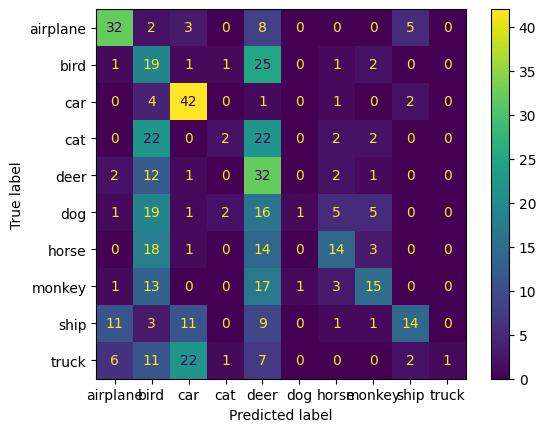

In [70]:
cm = metrics.confusion_matrix(actually, predicted)
display = metrics.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels = get_labels())
display.plot()
plt.show()